In [83]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#necessary libraries to handle dataframes and numeric data 
import pandas as pd
import numpy as np

# for visuals
import pylab as plt
import seaborn as sns
%matplotlib inline

# for data splitting into train and test
from sklearn.model_selection import train_test_split as tts

#the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#the metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# to standardize
from sklearn.preprocessing import StandardScaler

#for hyperparameter tuning
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.metrics import make_scorer 
from sklearn.model_selection import cross_val_score

#to save the model
import pickle

# to get the most important columns
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

In [2]:
data=pd.read_csv('../data/data_balanced.csv')

In [3]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.131956,56.372401,6.358667,1.0,0.0,0.0,1.0,1.0
1,3.803057,67.241081,1.872950,1.0,0.0,0.0,1.0,1.0
2,15.694986,175.989182,0.855623,1.0,0.0,0.0,1.0,1.0
3,26.711462,1.552008,4.603601,1.0,1.0,0.0,1.0,1.0
4,10.664474,1.565769,4.886521,1.0,0.0,0.0,1.0,1.0


In [4]:
X=data.drop('fraud', axis=1)
y=data['fraud']

In [5]:
X_train, X_test, y_train, y_test =tts(X, y, 
                                       random_state=42,
                                       stratify=y)


In [6]:
escalador = StandardScaler()   
 
escalador.fit(X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
 
X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = escalador.transform(X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])   
X_test[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = escalador.transform(X_test[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])  


Standardising the numeric columns 'distance_from_home', 'distance_from_last_transaction' and 'ration_to_median_purchase_price' since they have different scales . Data needs to be more or less on the same scale so that the model doesn´t give preference to one column over the other due to the scale being higher. Please note I fitted the train dataset and transformed both train and test with that information. You can read more about that in the below article
https://sebastianraschka.com/faq/docs/scale-training-test.html

In [7]:
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
34364,-0.407100,-0.197373,0.337115,1.0,0.0,0.0,1.0
21079,-0.309508,-0.131652,1.266614,1.0,0.0,0.0,1.0
100073,-0.353875,-0.106955,-0.472580,1.0,0.0,0.0,0.0
5769,-0.370031,-0.211139,0.479994,1.0,0.0,0.0,1.0
57842,-0.424345,-0.139255,0.617343,0.0,0.0,0.0,0.0


In [8]:
X_test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
116281,-0.268551,-0.192260,0.124602,1.0,0.0,1.0,1.0
61152,-0.389862,-0.209752,1.180487,1.0,0.0,0.0,1.0
105136,-0.099497,-0.190219,-0.198441,1.0,0.0,1.0,1.0
161774,-0.364760,5.560881,-0.355935,1.0,0.0,1.0,1.0
154787,-0.428819,-0.033384,-0.630839,0.0,1.0,0.0,0.0


This is how train and test looks like now 

In [9]:
lr=LogisticRegression()
rf=RandomForestClassifier()
dt=DecisionTreeClassifier()

Initiated the models

In [10]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Trained the models

In [11]:
y_test_pred_lr = lr.predict(X_test)
y_test_pred_rf = rf.predict(X_test)
y_test_pred_dt = dt.predict(X_test)

In [12]:
y_train_pred_lr = lr.predict(X_train)
y_train_pred_rf = rf.predict(X_train)
y_train_pred_dt = dt.predict(X_train)

Making predictions for both test and train data 

In [13]:
#Getting the metrics for each model for train and test 

def metrics(y_test, y_test_pred_model, y_train, y_train_pred_model, model):
    
    accuracy_test = accuracy_score(y_test, y_test_pred_model)
    precision_test = precision_score(y_test, y_test_pred_model)
    recall_test = recall_score(y_test, y_test_pred_model)
    f1_test = f1_score(y_test, y_test_pred_model)
    kappa_test = cohen_kappa_score(y_test, y_test_pred_model)

    accuracy_train = accuracy_score(y_train, y_train_pred_model)
    precision_train = precision_score(y_train, y_train_pred_model)
    recall_train = recall_score(y_train, y_train_pred_model)
    f1_train = f1_score(y_train, y_train_pred_model)
    kappa_train = cohen_kappa_score(y_train, y_train_pred_model)

    
    df = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                       'precision': [precision_test, precision_train],
                       'recall': [recall_test, recall_train], 
                       'f1': [f1_test, f1_train],
                       'kapppa': [kappa_test, kappa_train],
                       'set': ['test', 'train' ]})
    
    df['model'] = model
    return df


In [14]:
results_logistic = metrics(y_test, y_test_pred_lr, y_train, y_train_pred_lr, 'Logistic Regression')
# getting the metrics for logistic regression

In [15]:
results_randomforest = metrics(y_test, y_test_pred_rf, y_train, y_train_pred_rf, 'Random Forest')
# getting the metrics for random forest

In [16]:
results_decisiontree = metrics(y_test, y_test_pred_dt, y_train, y_train_pred_dt, 'Decision Tree')
# getting the metrics for decision tree

In [17]:
all_results=pd.concat([results_logistic, results_randomforest, results_decisiontree], axis=0)
#adding all the metrics in one dataframe 

In [18]:
all_results   

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression
0,0.999977,1.000000,0.999954,0.999977,0.999954,test,Random Forest
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Random Forest
0,0.999954,0.999954,0.999954,0.999954,0.999908,test,Decision Tree
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decision Tree


As per the metrics above, it looks like all models are working fairly well. Logistic Regression model is working slightly worse than the rest.

Random Forest and Decision Tree models seem to be working very well for both test and train samples. The train metrics seem to be a bit better than the test metrics. This difference is not as big however so there is no fear of the models being overfitted. 

All metrics are important but in the context of this project the one that interests me the most is the recall. I want it to be as high as possible since it is the metric that takes into account the False positives

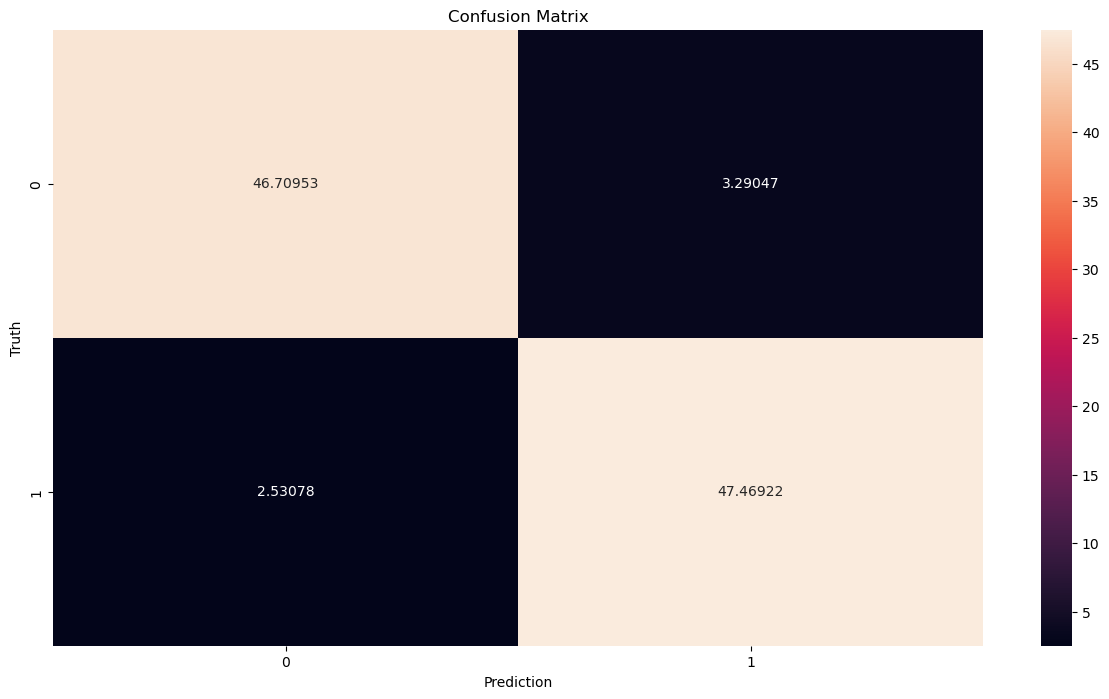

In [19]:
#confusion matrix for Logistic Regression
plt.figure(figsize=(15, 8))

conf_matrix = cm(y_test, y_test_pred_lr)

# Added 5 decimal places so I can compare to the tuned model later
percentage_matrix = conf_matrix / conf_matrix.sum() * 100
percentage_matrix_formatted = ["{:.5f}".format(value) for value in percentage_matrix.flatten()]

percentage_matrix_formatted = np.array(percentage_matrix_formatted).reshape(percentage_matrix.shape)

ax = sns.heatmap(percentage_matrix, annot=percentage_matrix_formatted, fmt='')

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show()


From the confusion matrix above we can see that logistic regression model has 47% True Negatives (Predicted not fraud when it is actually not fraud),  47% True Positive (Predicted fraud that is actually fraud), 2.5% False Negatives (Predicted no fraud when there was fraud) and 3.3% False Positives (Predicted fraud when there was no fraud) 

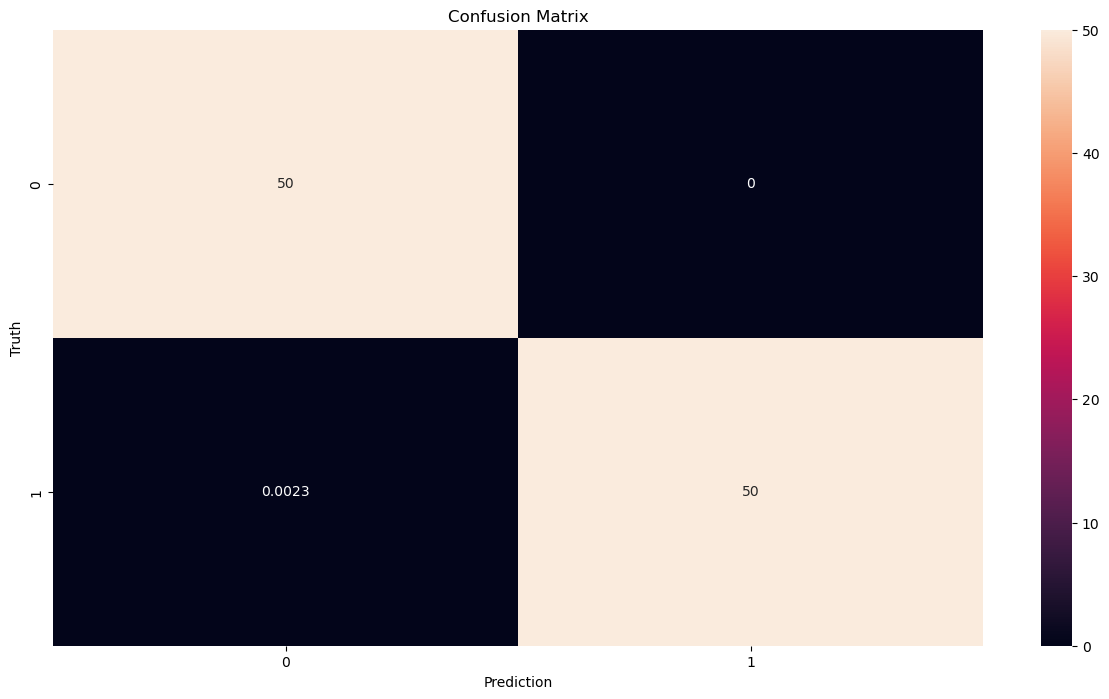

In [20]:
#confusion matrix for random forest
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_test_pred_rf)/cm(y_test, y_test_pred_rf).sum() * 100, 
               annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();


From the confusion matrix above we can see that the random forest model has 50% True Negatives (Predicted not fraud when it is actually not fraud),  50% True Positive (Predicted fraud that is actually fraud), 0.0023% False Negatives (Predicted no fraud when there was fraud) and 0% False Positives (Predicted fraud when there was no fraud) 

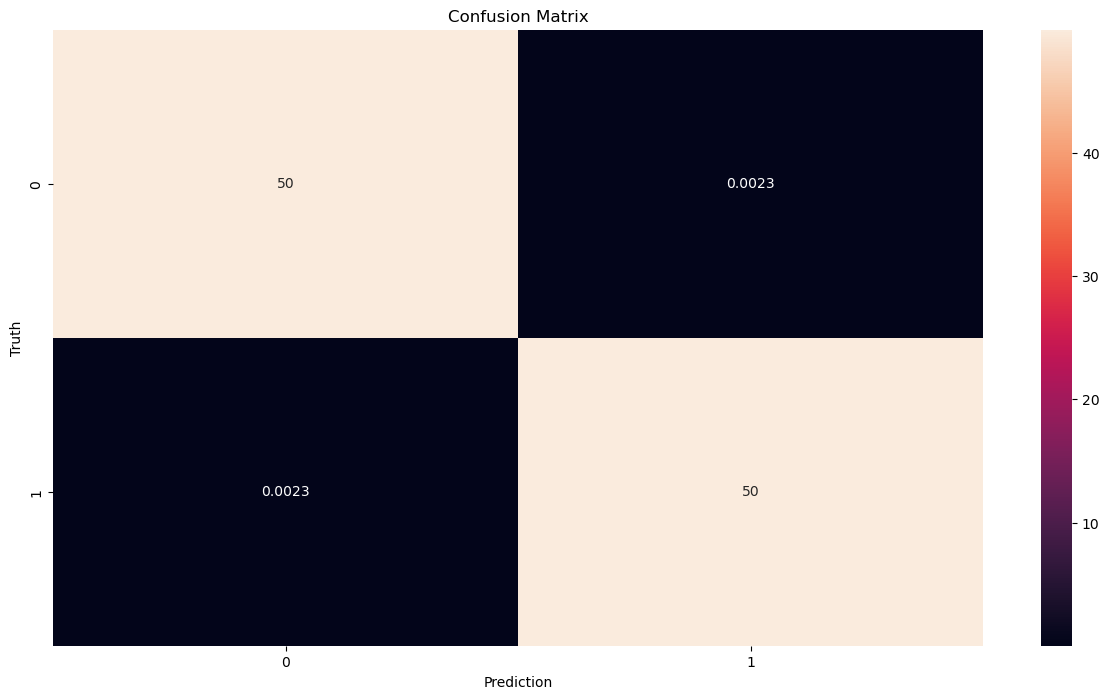

In [21]:
#confusion matrix for decision tree
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_test_pred_dt)/cm(y_test, y_test_pred_dt).sum() * 100, 
               annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();


From the confusion matrix above we can see that logistic regression model has 50% True Negatives (Predicted not fraud when it is actually not fraud),  50% True Positive (Predicted fraud that is actually fraud), 0.0023% False Negatives (Predicted not fraud when there was fraud) and 0.0023% False Positives (Predicted fraud when there was no fraud) 

Looking at the confusion matrix figures, the models that work the best again are random forest and decision tree.
It is preferable in this case to have more False Positives (top-right) than False Negatives (bottom-left) . We prefer to classify as fraud some non-fraud transactions than let fraud cases go by without any triggers. Both random forest and decision tree have 0.0023 % False Negatives so in this case I would prefer decision tree which has 0.0023% False Negatives while random forest has 0. 

## Hyper Parameter Tuning
Iterating with different hyperparameters for the logistic regression model , to see if I can improve the recall score. I will use hyperopt for that. 

In [22]:
#I want to improve the recall_score in the logistic regression model
recall_scorer = make_scorer(recall_score, greater_is_better=True)

space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -5, 5),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'random_state': hp.choice('random_state', [None, 42]),
    'solver': hp.choice('solver', ['liblinear'])
}

def objective(space):
    model = LogisticRegression(
        penalty=space['penalty'],
        C=space['C'],
        class_weight=space['class_weight'],
        random_state=space['random_state'],
        solver=space['solver'],
    )
    
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring=recall_scorer).mean()
    
    return {'loss': -cv_recall, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective,  
            space=space,    
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best hyperparameters:", best)


100%|█████████████████████████████████████████████| 100/100 [07:22<00:00,  4.43s/trial, best loss: -0.9504973127123619]
Best hyperparameters: {'C': 0.006758025060007171, 'class_weight': 1, 'penalty': 0, 'random_state': 0, 'solver': 0}


In [76]:
#Creating a  model for logistic regression with the best parameters found by hyperopt in the above cell. 
class_weight_map = {0: None, 1: 'balanced'}
best_class_weight = class_weight_map[best['class_weight']]
penalty_map = {0: 'l1', 1: 'l2'}
best_penalty = penalty_map[best['penalty']]
solver_map = {0: 'liblinear'}
best_solver = solver_map[best['solver']]

model = LogisticRegression(
    C=best['C'],
    class_weight=best_class_weight,
    penalty=best_penalty,
    random_state=best['random_state'],
    solver=best_solver,
)


In [77]:
model.fit(X_train, y_train)   #training the model

LogisticRegression(C=0.006758025060007171, class_weight='balanced',
                   penalty='l1', random_state=0, solver='liblinear')

In [78]:
#getting the predictions
y_pred_model_test = model.predict(X_test)
y_pred_model_train = model.predict(X_train)  

In [26]:
#calling the function metrics made above to get all the metrics for this newly created model 
results_model = metrics(y_test, y_pred_model_test, y_train, y_pred_model_train, 'Logistic Regression after tuning')
results_model

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941856,0.933738,0.951215,0.942395,0.883712,test,Logistic Regression after tuning
1,0.940208,0.931435,0.950375,0.940810,0.880416,train,Logistic Regression after tuning


In [27]:
# Concatenating the initial logistic regression model and the tuned logistic regression model so we can compare them 
logistic_comparison=pd.concat([results_logistic, results_model], axis=0)

In [28]:
logistic_comparison

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression
0,0.941856,0.933738,0.951215,0.942395,0.883712,test,Logistic Regression after tuning
1,0.940208,0.931435,0.950375,0.940810,0.880416,train,Logistic Regression after tuning


As we can see from the data above, there is some improvement in the recall score.

In [29]:
results_final=pd.concat([results_logistic, results_model, results_randomforest, results_decisiontree], axis=0)


In [30]:
results_final

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression
0,0.941856,0.933738,0.951215,0.942395,0.883712,test,Logistic Regression after tuning
1,0.940208,0.931435,0.950375,0.940810,0.880416,train,Logistic Regression after tuning
0,0.999977,1.000000,0.999954,0.999977,0.999954,test,Random Forest
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Random Forest
0,0.999954,0.999954,0.999954,0.999954,0.999908,test,Decision Tree
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decision Tree


In [86]:
results_final.to_csv('../data/model_metrics.csv')

Saving to csv file

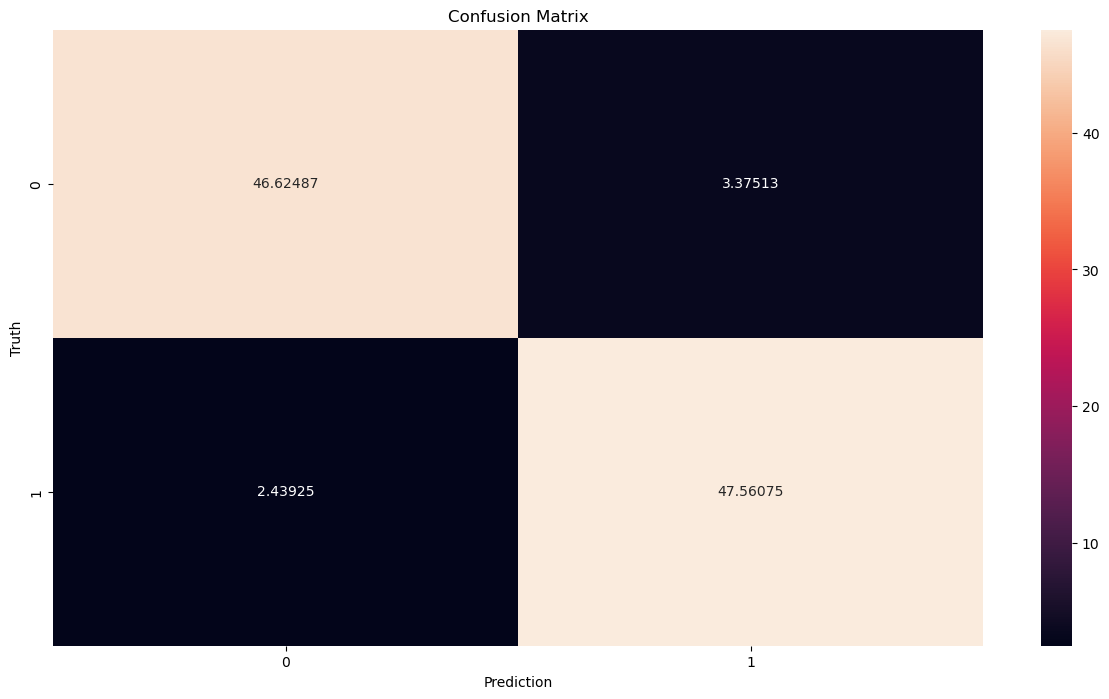

In [31]:
#confusion matrix for Tuned logistic regression. 
plt.figure(figsize=(15, 8))

conf_matrix = cm(y_test, y_pred_model_test)

percentage_matrix = conf_matrix / conf_matrix.sum() * 100

#I added 5 decimal places so we can see the difference from the default logistic regression model
percentage_matrix_formatted = ["{:.5f}".format(value) for value in percentage_matrix.flatten()]

percentage_matrix_formatted = np.array(percentage_matrix_formatted).reshape(percentage_matrix.shape)

ax = sns.heatmap(percentage_matrix, annot=percentage_matrix_formatted, fmt='')

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show()


The confusion matrix has changed a bit. The False Positives (which are the ones I prefer for this project) have increased and the False Negatives (the ones I wanted to decrease) have decreased. There is some improvement therefore but it is small. 

In [91]:
conf_matrix = cm(y_test, y_pred_model_test)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])

#Saving the confusion matrix to a csv file
conf_matrix_df.to_csv('../data/conf_matrix.csv')

In [32]:
pickle.dump(lr, open('logistic_regression_default.pk', 'wb'))  
pickle.dump(model, open('logistic_regression_tuned.pk', 'wb'))   
pickle.dump(rf, open('random_forest.pk', 'wb'))  
pickle.dump(dt, open('decision_tree.pk', 'wb'))  

Saving the models

## Getting the information needed for a power bi dashboard

In [54]:
#to see the importance of the columns 
x = sm.add_constant(data[[
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price',
    'repeat_retailer',
    'used_chip',
    'used_pin_number',
    'online_order'
]])

y = data['fraud']

modelo = sm.Logit(y, x) 
result = modelo.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.214586
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               174806
Model:                          Logit   Df Residuals:                   174798
Method:                           MLE   Df Model:                            7
Date:                Thu, 30 Nov 2023   Pseudo R-squ.:                  0.6904
Time:                        19:21:37   Log-Likelihood:                -37511.
converged:                       True   LL-Null:                   -1.2117e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -7.6161      0.053   -142.656    

distance_from_home: 0.10485193448124627
distance_from_last_transaction: 0.0341084606143813
ratio_to_median_purchase_price: 0.3057262170356387
repeat_retailer: 0.0032978662547908893
used_chip: 0.009856415536868576
used_pin_number: 0.0250881909883111
online_order: 0.06940297084453594


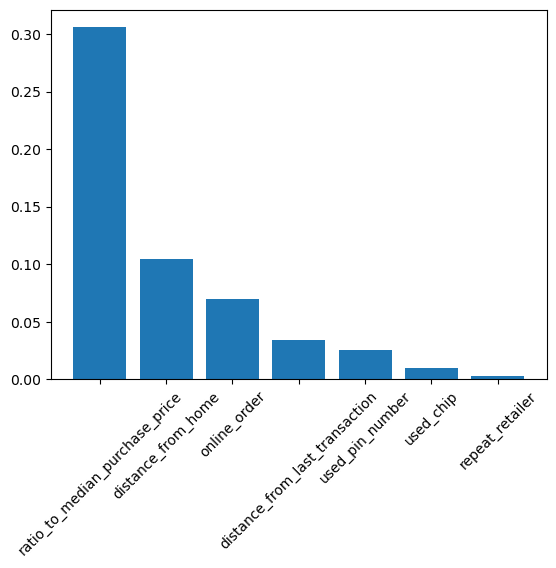

In [79]:
# Calculate permutation feature importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for feature, importance in zip(X.columns, perm_importance.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=45)
plt.show()


In [84]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean})
feature_importance

,Feature,Importance
0,distance_from_home,0.104852
1,distance_from_last_transaction,0.034108
2,ratio_to_median_purchase_price,0.305726
3,repeat_retailer,0.003298
4,used_chip,0.009856
5,used_pin_number,0.025088
6,online_order,0.069403


In [85]:
feature_importance.to_csv('../data/feature_importance.csv')

Saving to csv file